# Rare Variant eQTLs

I'm going to examine the eQTL results to determine whether any of the eQTLs are driven
by rare variants that are at a higher frequency in our subject set.

In [1]:
import glob
import os
import random
import subprocess

import cdpybio as cpb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import pybedtools as pbt
import seaborn as sns
import statsmodels.stats.multitest as smm
import vcf as pyvcf

import cardipspy as cpy
import ciepy

%matplotlib inline
%load_ext rpy2.ipython

dy_name = 'rare_variant_eqtls'

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    dy = os.path.join(ciepy.root, 'sandbox', 'tmp', dy_name)
    cpy.makedir(dy)
    pbt.set_tempdir(dy)
    
outdir = os.path.join(ciepy.root, 'output', dy_name)
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output', dy_name)
cpy.makedir(private_outdir)

In [2]:
fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'eqtls01', 'lead_variants.tsv')
lead_vars = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'eqtls02', 'lead_variants.tsv')
lead_vars2 = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'eqtls03', 'lead_variants.tsv')
lead_vars3 = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'unrelated_eqtls01', 'lead_variants.tsv')
unr_lead_vars = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'input_data', 'rnaseq_metadata.tsv')
rna_meta = pd.read_table(fn, index_col=0)
rna_meta_eqtl = rna_meta[rna_meta.in_eqtl]

fn = os.path.join(ciepy.root, 'output', 'input_data', 'subject_metadata.tsv')
subject_meta = pd.read_table(fn, index_col=0)

subject_meta_eqtl = subject_meta.ix[rna_meta_eqtl.subject_id]
rna_meta_eqtl = rna_meta_eqtl.merge(subject_meta_eqtl, left_on='subject_id', right_index=True)

In [3]:
lead_vars = lead_vars[lead_vars.perm_sig]
lead_vars = lead_vars[lead_vars.variant_type == 'snv']
lead_vars2 = lead_vars2[lead_vars2.perm_sig]
lead_vars2 = lead_vars2[lead_vars2.variant_type == 'snv']
lead_vars3 = lead_vars3[lead_vars3.perm_sig]
lead_vars3 = lead_vars3[lead_vars3.variant_type == 'snv']
unr_lead_vars = unr_lead_vars[unr_lead_vars.perm_sig]
unr_lead_vars = unr_lead_vars[unr_lead_vars.variant_type == 'snv']

In [4]:
af_cols = [x for x in lead_vars.columns if '_AF' in x]
lead_vars_af = lead_vars.dropna(subset=af_cols)
lead_vars2_af = lead_vars2.dropna(subset=af_cols)
lead_vars3_af = lead_vars3.dropna(subset=af_cols)

In [5]:
lead_vars[af_cols] = lead_vars[af_cols].fillna(0)

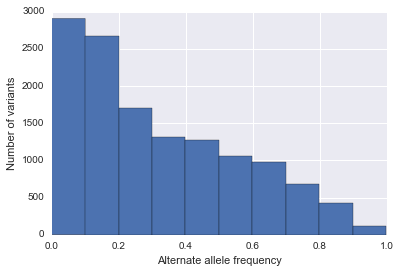

In [6]:
lead_vars_af.AF.hist()
plt.ylabel('Number of variants')
plt.xlabel('Alternate allele frequency');

The allele frequencies from 1,000 Genomes are for the alternate allele, 
so I need to take care when I define which allele is minor.

In [7]:
a = sum((lead_vars_af[af_cols] < 0.005).sum(axis=1) == len(af_cols))
b = sum((lead_vars_af[af_cols] > 1 - 0.005).sum(axis=1) == len(af_cols))
print('There are {} variants where the alternate is rare and {} '
      'where the reference is rare.'.format(a, b))

There are 143 variants where the alternate is rare and 0 where the reference is rare.


It doesn't seem like any of my eQTL lead variants that are in 1000 Genomes 
have rare reference alleles, so I can 
say that rare variants have the alternate allele as the minor allele.

In [8]:
lead_vars_af['rare'] = False
lead_vars_af.ix[lead_vars_af[(lead_vars_af[af_cols] < 0.005).sum(axis=1) == len(af_cols)].index, 'rare'] = True
a = lead_vars_af.rare.sum()
b = len(set(lead_vars_af.ix[lead_vars_af.rare, 'gene_id']))
print('There are {} rare lead variants for {} eGenes.'.format(a, b))

There are 143 rare lead variants for 106 eGenes.


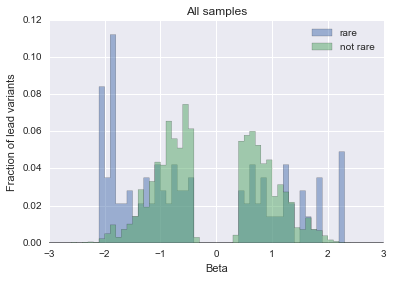

In [9]:
se = lead_vars_af[lead_vars_af.rare].beta
weights = np.ones_like(se) / float(se.shape[0])
se.hist(bins=np.arange(-3, 3.1, 0.1), label='rare', alpha=0.5, weights=weights, histtype='stepfilled')

se = lead_vars_af[lead_vars_af.rare == False].beta
weights = np.ones_like(se) / float(se.shape[0])
se.hist(bins=np.arange(-3, 3.1, 0.1), label='not rare', alpha=0.5, weights=weights, histtype='stepfilled')
plt.xlim(-3, 3)
plt.xlabel('Beta')
plt.ylabel('Fraction of lead variants')
plt.title('All samples')
plt.legend();

In [10]:
af_cols = [x for x in unr_lead_vars.columns if '_AF' in x]
unr_lead_vars_af = unr_lead_vars.dropna(subset=af_cols)
unr_lead_vars_af['rare'] = False
unr_lead_vars_af.ix[unr_lead_vars_af[(unr_lead_vars_af[af_cols] < 0.005).sum(axis=1) == 
                                     len(af_cols)].index, 'rare'] = True

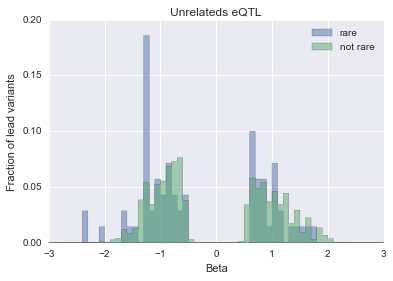

In [11]:
se = unr_lead_vars_af[unr_lead_vars_af.rare].beta
weights = np.ones_like(se) / float(se.shape[0])
se.hist(bins=np.arange(-3, 3.1, 0.1), label='rare', alpha=0.5, weights=weights, histtype='stepfilled')

se = unr_lead_vars_af[unr_lead_vars_af.rare == False].beta
weights = np.ones_like(se) / float(se.shape[0])
se.hist(bins=np.arange(-3, 3.1, 0.1), label='not rare', alpha=0.5, weights=weights, histtype='stepfilled')
plt.xlim(-3, 3)
plt.xlabel('Beta')
plt.ylabel('Fraction of lead variants')
plt.title('Unrelateds eQTL')
plt.legend();

In [12]:
def get_genotypes(df):
    genotypes = pd.DataFrame(np.nan, index=df.index, columns=rna_meta_eqtl.wgs_id)

    fn = '/projects/CARDIPS/analysis/cardips-ipsc-eqtl/private_output/eqtl_input/filtered_all/0000.vcf.gz'
    vcf_reader = pyvcf.VCFReader(open(fn))

    count = 0
    for i in df.index:
        if count % 1000 == 0:
            print(count)
        res = vcf_reader.fetch(df.ix[i, 'chrom'][3:], df.ix[i, 'end'],
                               df.ix[i, 'end'])
        r = res.next()

        hom_refs = set(rna_meta_eqtl.wgs_id) & set([x.sample for x in r.get_hom_refs()])
        hets = set(rna_meta_eqtl.wgs_id) & set([x.sample for x in r.get_hets()])
        hom_alts = set(rna_meta_eqtl.wgs_id) & set([x.sample for x in r.get_hom_alts()])

        genotypes.ix[i, hom_refs] = 0
        genotypes.ix[i, hets] = 1
        genotypes.ix[i, hom_alts] = 2
        count += 1
    return genotypes

In [13]:
out = os.path.join(private_outdir, 'genotypes.tsv')
if not os.path.exists(out):
    genotypes = get_genotypes(lead_vars_af)
    genotypes.to_csv(out, sep='\t')
else:
    genotypes = pd.read_table(out, index_col=0)
    
out = os.path.join(private_outdir, 'genotypes2.tsv')
if not os.path.exists(out):
    genotypes2 = get_genotypes(lead_vars2_af)
    genotypes2.to_csv(out, sep='\t')
else:
    genotypes2 = pd.read_table(out, index_col=0)
    
out = os.path.join(private_outdir, 'genotypes3.tsv')
if not os.path.exists(out):
    genotypes3 = get_genotypes(lead_vars3_af)
    genotypes3.to_csv(out, sep='\t')
else:
    genotypes3 = pd.read_table(out, index_col=0)

In [14]:
genotypes_f = genotypes.ix[lead_vars_af.index, rna_meta_eqtl.wgs_id]

In [15]:
lead_vars_af['ref_is_major'] = lead_vars_af.ac < lead_vars_af.ns

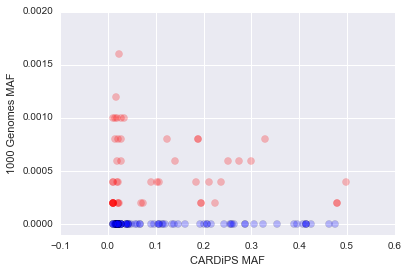

In [16]:
t = lead_vars_af[lead_vars_af.rare]
a = t[t.AF == 0]
plt.scatter(a.maf, a.AF, alpha=0.25, s=50)
a = t[t.AF != 0]
plt.scatter(a.maf, a.AF, alpha=0.25, s=50, color='red')
plt.ylim(-0.0001, 0.002)
plt.ylabel('1000 Genomes MAF')
plt.xlabel('CARDiPS MAF');

(0, 0.05)

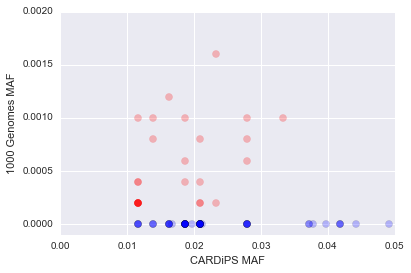

In [17]:
t = lead_vars_af[lead_vars_af.rare]
a = t[t.AF == 0]
plt.scatter(a.maf, a.AF, alpha=0.25, s=50)
a = t[t.AF != 0]
plt.scatter(a.maf, a.AF, alpha=0.25, s=50, color='red')
plt.ylim(-0.0001, 0.002)
plt.ylabel('1000 Genomes MAF')
plt.xlabel('CARDiPS MAF');
plt.xlim(0, 0.05)

In [18]:
lead_vars_uniq = lead_vars.drop_duplicates(subset='location')
lead_vars_uniq['minor_AF'] = lead_vars_uniq.AF
lead_vars_uniq.ix[lead_vars_uniq.minor_AF > 0.5, 'minor_AF'] = \
    1 - lead_vars_uniq.ix[lead_vars_uniq.minor_AF > 0.5, 'minor_AF']
lead_vars_uniq['ref_is_major'] = lead_vars_uniq.ac < lead_vars_uniq.ns

In [24]:
a = (lead_vars_uniq.AF == 0).value_counts()[False]
b = len(set(lead_vars_uniq.gene_id))
print('Obtained allele frequency for {:,} lead SNVs from {:,} eGenes from 1000 Genomes.\n'.format(a, b))

a = len(set(lead_vars_uniq[lead_vars_uniq.minor_AF < 0.005].gene_id))
nr = len(set(lead_vars_uniq[lead_vars_uniq.minor_AF < 0.005].location))
print('{:,} lead SNVs from {:,} eGenes were rare (MAF < 0.5%) in 1000 Genomes.'.format(nr, a))
n = (lead_vars_uniq[lead_vars_uniq.minor_AF < 0.005].maf > 0.05).value_counts()[True]
print('{:,} of these {:,} lead SNVs ({:.1f}%) are not rare among the 215 donors.'.format(n, nr, 100 * n / float(nr)))

a = (lead_vars_uniq.AF == 0).value_counts()[True]
print('{:,} of these {:,} lead SNVs were not seen in 1000 Genomes.'.format(a, nr))

a = len(set(lead_vars_uniq[(lead_vars_uniq.minor_AF < 0.005) & 
                           (lead_vars_uniq.minor_AF > 0)].gene_id))
b = len(set(lead_vars_uniq[(lead_vars_uniq.minor_AF < 0.005) &
                           (lead_vars_uniq.minor_AF > 0)].location))
print('{:,} of these {:,} lead SNVs from {:,} eGenes were observed in 1000 Genomes but were '
      'rare (MAF < 0.5%).\n'.format(b, nr, a))

Obtained allele frequency for 12,706 lead SNVs from 4,783 eGenes from 1000 Genomes.

305 lead SNVs from 185 eGenes were rare (MAF < 0.5%) in 1000 Genomes.
76 of these 305 lead SNVs (24.9%) are not rare among the 215 donors.
93 of these 305 lead SNVs were not seen in 1000 Genomes.
212 of these 305 lead SNVs from 118 eGenes were observed in 1000 Genomes but were rare (MAF < 0.5%).



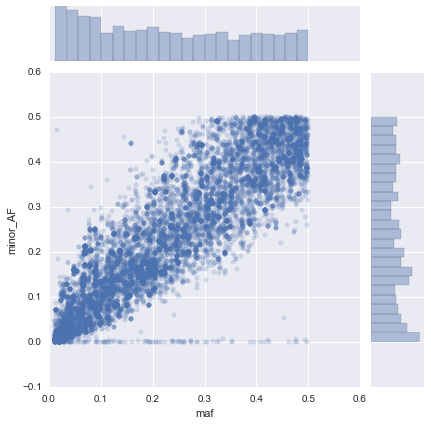

In [25]:
jg = sns.jointplot(lead_vars_uniq.maf, lead_vars_uniq.minor_AF, alpha=0.2, stat_func=None);

In [48]:
lead_vars_uniq.to_csv(os.path.join(outdir, 'lead_vars_uniq.tsv'), sep='\t')

In [29]:
wgs_meta = subject_meta.copy(deep=True)
wgs_meta = wgs_meta.ix[rna_meta[rna_meta.in_eqtl].subject_id]
se = pd.Series(rna_meta[rna_meta.in_eqtl].wgs_id.values, index=rna_meta[rna_meta.in_eqtl].subject_id)
wgs_meta.index = se[list(wgs_meta.index)].values

In [30]:
family_vc = subject_meta_eqtl.family_id.value_counts()
family_vc = family_vc[family_vc * 2 >= lead_vars_uniq.ac.min()]

In [31]:
for i in family_vc.index:
    se = genotypes.ix[lead_vars_uniq.index, 
                      rna_meta_eqtl[rna_meta_eqtl.family_id == i].wgs_id].sum(axis=1)
    c = '{}_maf'.format(i)
    lead_vars_uniq[c] = np.nan
    lead_vars_uniq.ix[lead_vars_uniq.ref_is_major, c] = se[lead_vars_uniq.ref_is_major.values] / (family_vc[i] * 2)
    lead_vars_uniq.ix[lead_vars_uniq.ref_is_major == False, c] = \
        (family_vc[i] * 2 - se[(lead_vars_uniq.ref_is_major == False).values]) / (family_vc[i] * 2)
    c = '{}_mac'.format(i)
    lead_vars_uniq.ix[lead_vars_uniq.ref_is_major, c] = se[lead_vars_uniq.ref_is_major.values]
    lead_vars_uniq.ix[(lead_vars_uniq.ref_is_major == False).values, c] = \
        (family_vc[i] * 2 - se[(lead_vars_uniq.ref_is_major == False).values])

In [38]:
t = lead_vars_uniq[lead_vars_uniq.minor_AF < 0.005]
num_fams = []
for i in t.index:
    se = genotypes.ix[i]
    mode = se.mode().values[0]
    num_fams.append(len(set(wgs_meta.ix[se[se != mode].index, 'family_id'])))
num_fams = pd.Series(num_fams)
a = sum(num_fams >= 2)
print('{:,} of {:,} rare lead variants were observed in more than one family.'.format(a, t.shape[0]))

272 of 305 rare lead variants were observed in more than one family.


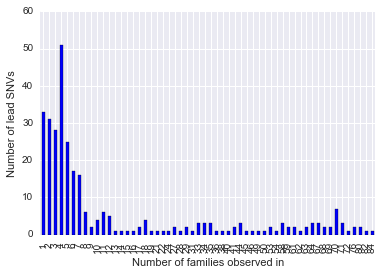

In [47]:
ax = num_fams.value_counts().sort_index().plot.bar()
ax.set_ylabel('Number of lead SNVs')
ax.set_xlabel('Number of families observed in');

In [49]:
num_fams.to_csv(os.path.join(outdir, 'rare_num_fams.tsv'), sep='\t')

In [ ]:
family_vc = subject_meta_eqtl.family_id.value_counts()
family_vc = family_vc[family_vc * 2 >= lead_vars_af.ac.min()]

In [21]:
for i in family_vc.index:
    se = genotypes_f[rna_meta_eqtl[rna_meta_eqtl.family_id == i].wgs_id].sum(axis=1)
    c = '{}_maf'.format(i)
    lead_vars_af[c] = np.nan
    lead_vars_af.ix[lead_vars_af.ref_is_major, c] = se[lead_vars_af.ref_is_major] / (family_vc[i] * 2)
    lead_vars_af.ix[lead_vars_af.ref_is_major == False, c] = \
        (family_vc[i] * 2 - se[lead_vars_af.ref_is_major == False]) / (family_vc[i] * 2)
    c = '{}_mac'.format(i)
    lead_vars_af.ix[lead_vars_af.ref_is_major, c] = se[lead_vars_af.ref_is_major]
    lead_vars_af.ix[lead_vars_af.ref_is_major == False, c] = \
        (family_vc[i] * 2 - se[lead_vars_af.ref_is_major == False])

In [22]:
c = '{}_maf'.format(family_vc.index[1])
t = lead_vars_af[lead_vars_af[c] > lead_vars_af.maf]
t = t[t.rare]
t = t[t.maf < 0.05]

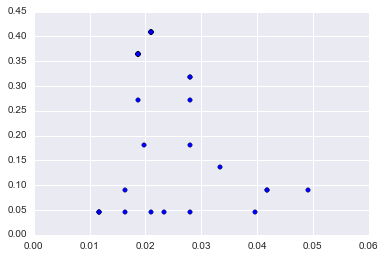

In [23]:
plt.scatter(t.maf, t[c])

In [24]:
for i in family_vc.index:
    c = '{}_mac'.format(i)
    a = set(subject_meta.ix[subject_meta.family_id == i, 'ethnicity_group'])
    print(i, len(set(lead_vars_af.ix[lead_vars_af.ac == lead_vars_af[c], 'gene_id'])), list(a))

('abb401f1-5c3e-48ed-8c55-839ce2afe7e6', 1, ['Hispanic', 'African American', 'Multiple ethnicities reported', 'European'])
('84fda65d-9a06-4bbe-ad75-a24773724c32', 2, ['Asian', 'Multiple ethnicities reported', 'European'])
('a56f620d-82e4-4963-a80b-b97c091c4b06', 0, ['Multiple ethnicities reported', 'European'])
('319aca18-4ca4-444d-80ca-3c0065169793', 0, ['Asian'])
('0a78a1f4-540f-4f63-acd1-197228abad11', 0, ['European'])
('cec0061a-f86c-4d8f-979f-3c6edce2d905', 0, ['European'])
('24bb1db3-75fb-4c66-9ccd-8e98dc3fadf1', 0, ['European'])
('f9d0c0e4-4408-469a-8c14-e65352142cc9', 0, ['Asian'])
('225e50a6-3386-4df5-b47d-6a564cde04d3', 0, ['Asian'])
('a23bb99f-656b-4853-a029-2400ec16dae6', 0, ['European'])
('2c54a579-6ba4-45be-b3cc-e2003349acd7', 0, ['European'])
('0fef459e-1c58-4bf8-9b2e-48da79a78536', 0, ['European'])
('bdc08658-e9d6-45ce-8f51-57775682c800', 0, ['European'])
('25e71a57-1993-4844-a0e1-f273522a8d05', 0, ['European'])
('bdc7cf80-9790-410e-abf0-6085d2881790', 0, ['European'])

In [21]:
subject_meta[subject_meta.family_id == '84fda65d-9a06-4bbe-ad75-a24773724c32'].head()

,sex,age,family_id,father_id,mother_id,twin_id,ethnicity_group
id,,,,,,,
f549b5fa-a6c0-49fb-8a07-dda4f72ff076,M,51.9,84fda65d-9a06-4bbe-ad75-a24773724c32,NaN,NaN,NaN,European
2a81d225-42f6-43cf-904a-be64bf3fd2d7,F,45.2,84fda65d-9a06-4bbe-ad75-a24773724c32,6a784dd7-9c48-4841-93f9-930b9de49cc4,ae3637d4-493e-482e-bc48-6915e30ffb9c,NaN,Multiple ethnicities reported
e932e556-59a6-4f70-9b4c-ef5f69dac3ce,F,48.3,84fda65d-9a06-4bbe-ad75-a24773724c32,6a784dd7-9c48-4841-93f9-930b9de49cc4,ae3637d4-493e-482e-bc48-6915e30ffb9c,NaN,Multiple ethnicities reported
de9c74e8-d399-465e-92cd-904a0e323bca,M,50.2,84fda65d-9a06-4bbe-ad75-a24773724c32,6a784dd7-9c48-4841-93f9-930b9de49cc4,ae3637d4-493e-482e-bc48-6915e30ffb9c,NaN,European
f772212a-cd98-40f9-bdcd-e75740c1f6be,F,18.1,84fda65d-9a06-4bbe-ad75-a24773724c32,f549b5fa-a6c0-49fb-8a07-dda4f72ff076,e932e556-59a6-4f70-9b4c-ef5f69dac3ce,NaN,European


In [21]:
lead_vars_af.to_csv(os.path.join(outdir, 'lead_vars_af.tsv'), sep='\t')
unr_lead_vars_af.to_csv(os.path.join(outdir, 'unr_lead_vars_af.tsv'), sep='\t')

In [28]:
tdf = lead_vars_af[lead_vars_af.rare]

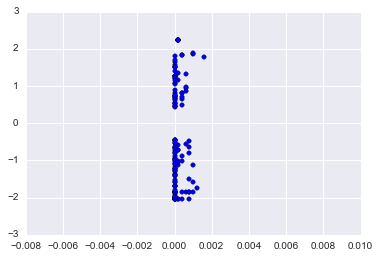

In [31]:
plt.scatter(tdf.AF, tdf.beta)

In [46]:
t = lead_vars_af[lead_vars_af.ac == lead_vars_af['84fda65d-9a06-4bbe-ad75-a24773724c32_mac']]
t.sort_values(by='pvalue', inplace=True)
t.drop_duplicates(subset=['gene_id']).T.head(26)

,chr14:23615514-23615515:ENSG00000100897.13,chr11:66914128-66914129:ENSG00000173992.4
chrom,chr14,chr11
start,23615514,66914128
end,23615515,66914129
marker_id,14:23615515_G/A_rs117617634,11:66914129_A/G
ns,215,215
ac,9,8
callrate,1,1
genocnt,206/9/0,207/8/0
maf,0.02093,0.0186
stat,-4.8404,-4.4335


In [47]:
t = lead_vars_af[lead_vars_af.ac == lead_vars_af['abb401f1-5c3e-48ed-8c55-839ce2afe7e6_mac']]
t.sort_values(by='pvalue', inplace=True)
t.drop_duplicates(subset=['gene_id']).T.head(26)

,chr7:111481507-111481508:ENSG00000006652.9
chrom,chr7
start,111481507
end,111481508
marker_id,7:111481508_C/T
ns,215
ac,6
callrate,1
genocnt,209/6/0
maf,0.01395
stat,4.374


TODO: Are any of the lead variants for the second or third eQTLs rare?

In [50]:
sum(lead_vars2.AF < 0.005)

49

In [51]:
sum(lead_vars3.AF < 0.005)

46